# Models and Lyrics

This project aims to:
1. Use text classification methods to examine lyric sentiment for songs in English.
2. Train a large language model (LLM) to generate lyrics in English. I would also like to develop new features - such a genre or mood - to enable the model to handle more complex queries. For example:
    * Lyrics + Rock + Happy
    * Lyrics + Pop + Nostalgic
    

The project will be using the  [Genius Song Lyric](https://www.kaggle.com/datasets/carlosgdcj/genius-song-lyrics-with-language-information/data?select=song_lyrics.csv) dataset from Kaggle.

<!-- Project steps:
(1) Data exploration
(2) Data preprocessing
(3) Model selection
(4) Training
(5) Fine-tuning and validation
(6) Deploy model and test
(7) Add new features, and repeat steps 2-6. -->

# Exploratory Data Analysis

In [ ]:
#Read data using chunks

import pandas as pd

file_path = 'song_lyrics.csv'

chunk_size = 100000

chunks = []

for chunk in pd.read_csv(file_path, chunksize=chunk_size):

    chunks.append(chunk)

# Concatenate all chunks into a single DataFrame if needed
song_lyrics_full_df = pd.concat(chunks, ignore_index=True)




In [ ]:
# Generate sample data for EDA
song_lyrics_sample_df =  song_lyrics_full_df.groupby('year', group_keys=False).apply(lambda x: x.sample(frac=0.01)) #take a sample based on xyz?

### Variable Descriptions

Description of each column in the dataset, as provided on [Genius Song Lyrics](https://www.kaggle.com/datasets/carlosgdcj/genius-song-lyrics-with-language-information/data?select=song_lyrics).

| Variable | Description |
|:--------|:--------|
|  title   |  track name  | 
|  tag   |  track genre   | 
|  artist   |  artist name | 
|  year | year of release  |
|  views | number of views on [genius.com](https://genius.com)  |
|  features |  artists who feature on the track |
|  lyrics |  track lyrics |
|  id | track id, provided by genius  |
|  language_cld3 | lyrics language according to CLD3  |
|  language_ft | lyrics language according to FastText's langid  |
|  language |  Combines language_cld3 and language_ft. Only has a non NaN entry if they both "agree" |


### Views

When classifying or generating lyrics, it's important to be analysing lyrics that matter. We can use track views as a proxy for whether the lyrics matter.

The distribution of views is heavily skewed to the left. Over half of the songs in the dataset have been viewed less than 100 times, and 75% less than 500 times. 

<!--perhaps we could use views per year?-->

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a box plot to visualize and summarize distribution
sns.boxplot(x=song_lyrics_full_df['views'])
plt.title('Box Plot of view')
plt.show()

print(song_lyrics_full_df['views'].describe())


### Tracks by Year

It appears the dataset has tracks from the *year zero* and *2100*, with an exponential spike in tracks as we close in on the millenia.

In [ ]:
import plotly.express as px

# year - number of ids (i.e. tracks) per year. This should be plotted. (tracks by year)
track_per_year_df = song_lyrics_full_df.groupby('year').agg({'id':'count'}).reset_index()

fig = px.line(track_per_year_df , x = "year", y = "id", title = "Number of tracks per year",labels = {"id":"# tracks"})
fig.show()

The evolution of popular music is said to have began in the late 19th century in *Tin Pan Alley*, an area of New York. So perhaps filtering the data from 1880 will allow us to chart the rise in tracks more closely.

<!-- https://open.lib.umn.edu/mediaandculture/chapter/6-2-the-evolution-of-popular-music/ -->

In [ ]:
# year - number of ids (i.e. tracks) per year. This should be plotted. (tracks by year)
song_lyrics_from_1880_df = song_lyrics_full_df[(song_lyrics_full_df['year'] >= 1880)]
track_per_year_from_1880_df  = song_lyrics_from_1880_df.groupby('year').agg({'id':'count'}).reset_index()

fig = px.line(track_per_year_from_1880_df , x = "year", y = "id", title = "Number of tracks per year", labels = {"id":"# tracks"})
fig.show()

The rapid rise reaches its peak in 2020 with over 575,000 tracks. There does seem to be a noticeable dip in number of tracks in 2016. This will require further investigation.

### Genre

The most popular genre of music is, understandably, pop. Rap is not too far behind, which is understandable as Genius (orginally Rap Genius) initally launched with a focus on hip-hop.

In [ ]:
# tag/genre - simple table, I imagine it's dominate by pop and rock (popular genre)
popular_genre_df = song_lyrics_full_df.groupby('tag').agg({'id':'count'}).reset_index()
popular_genre_df = popular_genre_df.sort_values(by = 'id',ascending = False)
popular_genre_df = popular_genre_df.rename(columns = {"id" : "number of tracks"})
display(popular_genre_df) 

### What is *misc*?
There appears to be a genre called *misc*. On closer inspection, it contains poems, books and bible passages. Given that these are not song lyrics, these will also need to be removed before our analysis and modelling.

<!--https://genius.com/Genius-tags-music-genres-countries-languages-annotated -->

In [ ]:
genre_misc_df = song_lyrics_full_df[(song_lyrics_full_df['tag'] == "misc")]
genre_misc_df = genre_misc_df.head(10)

display(genre_misc_df)

### Artists

When it comes to the number of tracks, there is only one artist in the top ten that is a musician/band - *The Grateful Dead* with over 2,100 tracks. The list is populated by *Genius translations*, the most popular being *Genius Romanizations* which enables people to pronounce lyrics phoentically.

However, the list of artists is more familiar if we rank them by total views. One Genius translation survives, but *Drake* has the crown. As expected, the list is dominated by rap and hip-hop.

In [ ]:
#Artists - top 10 number by id (popular_artists_df)
artist_top_ten_df = song_lyrics_full_df.groupby('artist').agg({'id':'count'}).reset_index()
artist_top_ten_df['rank'] = artist_top_ten_df['id'].rank(ascending= False)
artist_top_ten_df = artist_top_ten_df.sort_values(by = 'rank')
artist_top_ten_df = artist_top_ten_df.rename(columns = {"id" : "number of tracks"})
artist_top_ten_df = artist_top_ten_df.head(10)

display(artist_top_ten_df)


In [ ]:
# Artist - top 10 artists by number of views (popular_artist_x_views_df)
artist_top_ten_views_df = song_lyrics_full_df.groupby('artist').agg({'views':'sum'}).reset_index()
artist_top_ten_views_df['rank'] = artist_top_ten_views_df['views'].rank(ascending= False)
artist_top_ten_views_df = artist_top_ten_views_df.sort_values(by = 'rank')
artist_top_ten_views_df = artist_top_ten_views_df.head(10)

display(artist_top_ten_views_df)

### Artists formally known as *Genius*

There appears to be around 400 artists containing the word "Genius". While many of them are *Genius Translations*, there are notable exceptions (Perfume Genius, boygenius). In an absence of a systematic way of identifying Genius Translations from Non-Genius Translations, it will be easier to filter them out as we prepare our data for analysis and modelling.

In [ ]:
# Artists with "Genius" in their title

genius_artists_df = song_lyrics_full_df[song_lyrics_full_df['artist'].str.contains('Genius', case=False, na=False)]
genius_artists_df = genius_artists_df.groupby('artist').agg({'id':'count'}).reset_index()

display(genius_artists_df)



### Features

Similar to artists, the *Genius Translations* dominate the number of features, but Drake retains another crown when it comes to total views.

In [ ]:
# features (most popular feature?) - most features (popular_features_df)
# Need to remove {} brakcets
features_top_ten_views_df = song_lyrics_full_df.groupby('features').agg({'id':'count'}).reset_index()
features_top_ten_views_df['rank'] = features_top_ten_views_df['id'].rank(ascending= False)
features_top_ten_views_df = features_top_ten_views_df.rename(columns = {"id" : "number of tracks"})
features_top_ten_views_df = features_top_ten_views_df.sort_values(by = 'rank')
features_top_ten_views_df = features_top_ten_views_df.head(10)

display(features_top_ten_views_df)

In [ ]:
# features (most popular feature?) - most features (popular_features_df)
# Need to remove {} brakcets
features_top_ten_views_df = song_lyrics_full_df.groupby('features').agg({'views':'sum'}).reset_index()
features_top_ten_views_df['rank'] = features_top_ten_views_df['views'].rank(ascending= False)
features_top_ten_views_df = features_top_ten_views_df.sort_values(by = 'rank')
features_top_ten_views_df = features_top_ten_views_df.head(10)

display(features_top_ten_views_df)

### Language

Unsurprisingly, European languages dominates the most number of tracks and views, across time and since the dawn of popular music in 1880.
There are over 3 million english language tracks, although a proportion of them will be *Genius English Translations*. In any case, because the aim is to analyse lyric sentiment and generate lyrics in English, there seems to be enough data in whcih to make an attempt.

In [ ]:
#Most popular language
popular_lang_df = song_lyrics_full_df.groupby('language').agg({'id':'count','views':'sum'}).reset_index()
popular_lang_df ['rank'] = popular_lang_df ['views'].rank(ascending= False)
popular_lang_df  = popular_lang_df.rename(columns = {"id" : "number of tracks"})
popular_lang_df  = popular_lang_df.sort_values(by = 'rank')
popular_lang_df  = popular_lang_df.head(10)

display(popular_lang_df)

In [ ]:
#Most popular language since dawn of popular music
popular_lang_1880_df = song_lyrics_from_1880_df.groupby('language').agg({'id':'count','views':'sum'}).reset_index()
popular_lang_1880_df ['rank'] = popular_lang_1880_df  ['views'].rank(ascending= False)
popular_lang_1880_df   = popular_lang_1880_df .rename(columns = {"id" : "number of tracks"})
popular_lang_1880_df   = popular_lang_1880_df .sort_values(by = 'rank')
popular_lang_1880_df   = popular_lang_1880_df .head(10)

display(popular_lang_1880_df)

# #Most popular langauge by views and year
# popular_lang_views_df = song_lyrics_sample_df.groupby(['year','language']).agg({'views':'sum'}).reset_index()
# display(popular_lang_views_df)

### Lyrics
Pink Floyd mean a lot to me. They are the first band I listened to meaningfully. I repeatedely watched live versions of *Us and Them* and *Wish You Were Here* on *Delicate Sound of Thunder* VHS.

We can use these tracks to examine the format of the lyrics in the dataset. A couple of things stand out:

* Special characters to denote line breaks (\n).
* Square brackets contain section markers (e.g. verse), song credits and features. The section makers could be very useful as tokens in a large language model to generate lyrics for a specific section (i.e. lyrics + rock + verse)


In [ ]:
us_and_them_df = song_lyrics_full_df[(song_lyrics_full_df['artist'] == "Pink Floyd") & (song_lyrics_full_df['title'] == "Us and Them")]

display(us_and_them_df['lyrics'].values)


In [ ]:
wish_you_were_here_df = song_lyrics_full_df[(song_lyrics_full_df['artist'] == "Pink Floyd") & (song_lyrics_full_df['title'] == "Wish You Were Here")]

display(wish_you_were_here_df['lyrics'].values)

# Using text classification to examine lyric sentiment

The great songs make us *feel*. Joy. Elation. Danger. Extreme feelings often occur in the same song (*soon* by mbv anyone?).

The real power lies in the congurance between music and lyrics.

For example, the opening lyric of *Blue* by Joni Mitchell is "Blue" accompanied by a minor chord. Minor chords evoke negative feelings (i.e. sadness). Thus the utterance of the word blue feels...really blue. Just imagine if it were played with a major chord instead? A negative word contrasted with chords that evoke positive feelings.

TBC: something about intervals here.

To that end, I would like to classify lyrics to English songs using two sets of labels:

1. Which songs evoke positive, negative or neutral feelings?
2. Which songs evoke specific emotions (i.e. joy, danger)?

For each question, we will use a range of text-classification methods.

For further information on the importance of intervals and emotions:

* [Gravity Sound](https://gravitysound.studio/blogs/news/how-interval-music-theory-can-trick-your-brain)
* [How Music Really Works](https://www.howmusicreallyworks.com/chapter-four-scales-intervals/intervals-emotional-power-music.html)


### Data Preprocessing

In preparation for text classification, we will filter our data based on the findings from our EDA:

* Keep tracks with English lyrics.
* Remove artists which contain the word "Genius"
* Remove tracks under the "misc" genre.
* Keep songs since 1880, the dawn of popular music.
* Remove songs after 2022, the year this dataset "ends".
* Keep songs with at least 448 views (i.e. top 25% of tracks).

We also need to clean the lyrics. This involves removing text between the square brackets, such as section markers, song credits, features, and apply standard cleaning processes. This will enable text classification to be more effective. We can use the lyrics to *Wish You Were Here* to show the impact of cleaning the lyrics.

TODO: need to check the character length of the lyrics - are they longer than the max?

TODO: remove songs with a low number of views? Do a histogram of views? We want to learn from well known songs.


In [ ]:
#Data Preprocessing
import re

#Clean text
def clean_lyrics(text):
    
    #Remove text between brackets
    text = re.sub(r'\[.*?\]', '', text)
    
    # Remove newline and tab characters
    text = re.sub(r'[\n\t]', ' ', text)
    
    # Remove special characters and digits (optional, depending on use case)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    
    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Convert to lowercase
    text = text.lower()
    
    return text

# Example usage of cleaning lyrics to wish you were here
wish_you_were_here_clean = clean_lyrics(wish_you_were_here_df.iloc[0,6])
display(wish_you_were_here_clean)


In [ ]:
#Undertake data cleaning
song_lyrics_clean_df = song_lyrics_full_df.copy()

#Filter data for english lyrics
song_lyrics_clean_df = song_lyrics_clean_df[(song_lyrics_clean_df['language'] == 'en')]

#Filter data to remove artists containing "Genius"
song_lyrics_clean_df  = song_lyrics_clean_df [~song_lyrics_clean_df ['artist'].str.contains('Genius', case=False, na=False)]

#Filter for data between 1880 and 2022
song_lyrics_clean_df = song_lyrics_clean_df[(song_lyrics_clean_df['year'] >= 1880) & (song_lyrics_clean_df['year'] <= 2022)]

#Filter for songs with more than 448 views - so only the top 25% of lyrics.
song_lyrics_clean_df = song_lyrics_clean_df[(song_lyrics_clean_df['views'] >= 448)]

#Filter data for misc genre
song_lyrics_clean_df = song_lyrics_clean_df[~(song_lyrics_clean_df['tag'] == 'misc')]

#Clean text
song_lyrics_clean_df['lyrics'] = song_lyrics_clean_df['lyrics'].apply(clean_lyrics)

# Drop unecessary columns
song_lyrics_clean_df = song_lyrics_clean_df.drop(columns=['id','language_cld3','language_ft'])


In [1]:
import pandas as pd

#Write df to csv
#song_lyrics_clean_df.to_csv("song_lyrics_clean_df.csv")

song_lyrics_clean_df = pd.read_csv("song_lyrics_clean_df.csv")

# Desired total sample size
total_sample_size = 2000

# Calculate the number of rows in each category
genre_counts = song_lyrics_clean_df['tag'].value_counts()

# Calculate the sample size for each category
stratified_sample_sizes = (genre_counts / genre_counts.sum() * total_sample_size).round().astype(int)

# Perform stratified sampling
song_lyrics_clean_sample_df = song_lyrics_clean_df.groupby('tag').apply(lambda x: x.sample(stratified_sample_sizes.loc[x.name], random_state=1)).reset_index(drop=True)

#Save output to csv
song_lyrics_clean_sample_df.to_csv('song_lyrics_clean_sample.csv')



/var/folders/52/f3r19jwn72s9q8h3h8bsc8vh0000gn/T/ipykernel_2145/546745907.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  song_lyrics_clean_sample_df = song_lyrics_clean_df.groupby('tag').apply(lambda x: x.sample(stratified_sample_sizes.loc[x.name], random_state=1)).reset_index(drop=True)


## Which songs evoke positive, negative or neutral feelings?

### Zero-Shot Classification

<!--write something about using zero shot classification -->

In [2]:
# Developing the zero-shot model
import torch
from transformers import pipeline

#Added to ensure that it uses the apple M1 cores.
#https://github.com/jeffheaton/app_deep_learning/blob/main/install/pytorch-install-aug-2023.ipynb
has_gpu = torch.cuda.is_available()
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"
#device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Initialize the zero-shot classification pipeline
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli",device=device)


In [3]:
# Define candidate labels
sentiment_labels = ["positive","neutral","negative"]

#Lyrics
song_df = song_lyrics_clean_df[(song_lyrics_clean_df['artist'] == "Pink Floyd") & (song_lyrics_clean_df['title'] == "Wish You Were Here")]
song_lyrics = song_df.iloc[0,6]

# Perform zero-shot classification
sentiment_result = classifier(song_lyrics, sentiment_labels)

#Sentiment results
print("Sentiment Labels:", sentiment_labels)
print("Classification Result:", sentiment_result)


Sentiment Labels: ['positive', 'neutral', 'negative']
Classification Result: {'sequence': '{}', 'labels': ['negative', 'neutral', 'positive'], 'scores': [0.3641412556171417, 0.35487520694732666, 0.28098350763320923]}


In [4]:
#Create dataset for zero shot results
song_lyrics_zero_shot_df = song_lyrics_clean_sample_df.copy()

#Sentiment labels
sentiment_labels = ["positive","neutral","negative"]

# Function to classify text and store results
def classify_lyrics(lyrics, candidate_labels):
    result = classifier(lyrics, candidate_labels)
    return result

# Apply classification to each row and store results
song_lyrics_zero_shot_df['classification'] = song_lyrics_zero_shot_df['lyrics'].apply(lambda x: classify_lyrics(x, sentiment_labels))

# Extract the scores for each label
for label in sentiment_labels:
    song_lyrics_zero_shot_df[label] = song_lyrics_zero_shot_df['classification'].apply(lambda x: x['scores'][x['labels'].index(label)])

# Extract the predicted label and score
song_lyrics_zero_shot_df['predicted_label'] = song_lyrics_zero_shot_df['classification'].apply(lambda x: x['labels'][0])
song_lyrics_zero_shot_df['predicted_score'] = song_lyrics_zero_shot_df['classification'].apply(lambda x: x['scores'][0])

# Drop the intermediate 'Classification' column
song_lyrics_zero_shot_df = song_lyrics_zero_shot_df.drop(columns=['classification'])

#Write results to csv
#song_lyrics_zero_shot_df.to_csv('song_lyrics_zero_shot_df.csv')


,predicted_label,number of predictions
0,negative,1511
1,neutral,12
2,positive,476


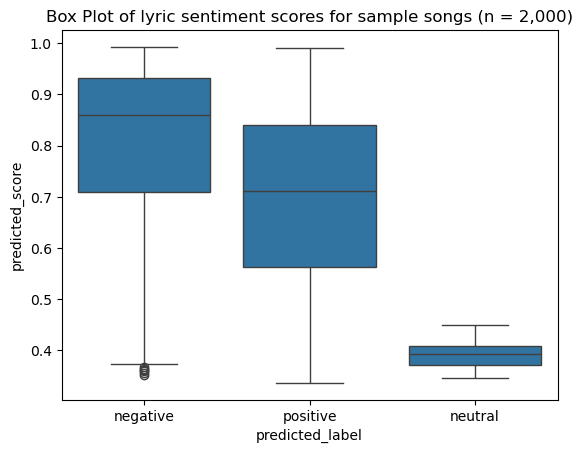

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

#Display table of results
song_lyrics_zero_shot_summary_df = song_lyrics_zero_shot_df.groupby('predicted_label').agg({'artist':'count'}).reset_index()
song_lyrics_zero_shot_summary_df = song_lyrics_zero_shot_summary_df.rename(columns = {"artist" : "number of predictions"})
display(song_lyrics_zero_shot_summary_df)

# Create a box plot to visualize and summarize distribution
sns.boxplot(x='predicted_label', y = 'predicted_score', data = song_lyrics_zero_shot_df)
plt.title('Box Plot of lyric sentiment scores for sample songs (n = 2,000)')
plt.show()


## Which songs evoke specific emotions (i.e. joy, danger)?

In [ ]:
#Interval labels - perhaps pick 6-8 emotions that capture the majority of the feelings you get from a song.
#Need to make sure these are not overlapping
#Maybe use some analysis to check how similar some words are to each other
#interval_labels = ["happiness","serenity","aspiration","stability","openness","mysterious","sadness","danger"]
#interval_result = classifier(song_lyrics, interval_labels)

# LLM model for writing lyrics

TBC

<!-- 1. Repeat data pre-processing steps.
2. Add a special token for genre based on "tag"
3. Tokens will need to be split by /n, as these indicate new lines
4. Model could be improved by shifting the window between /n to improve context of lines
5. Create a training and a validation set. Make sure proportion of each genre is represented. -->

In [ ]:
# #Add genre tag to the lyrics
# song_lyrics_df['lyrics'] = '<genre_' + song_lyrics_df['tag'] + '> ' + song_lyrics_df['lyrics']

# print(song_lyrics_df['lyrics'][1])